<a href="https://colab.research.google.com/github/jayabban/Data-Science/blob/main/Early_Gastric_Cancer_Transfer_Learning_Fresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from keras.models import Sequential
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np

# **Define variables**

In [3]:
IMAGE_SIZE = [224, 224]
train_path = '/content/drive/MyDrive/Colab Notebooks/Research_Early_Cancer_Detection/Early_Cancer_Dataset/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/Research_Early_Cancer_Detection/Early_Cancer_Dataset/test'

# **Import the Vgg 16 library**

In [4]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [5]:
for layer in vgg.layers:
  layer.trainable = False

In [6]:
folders = glob('/content/drive/MyDrive/Colab Notebooks/Research_Early_Cancer_Detection/Early_Cancer_Dataset/train/*')

In [7]:
folders

['/content/drive/MyDrive/Colab Notebooks/Research_Early_Cancer_Detection/Early_Cancer_Dataset/train/Non_Cancer_Classified',
 '/content/drive/MyDrive/Colab Notebooks/Research_Early_Cancer_Detection/Early_Cancer_Dataset/train/Early_Cancer']

In [8]:
x = Flatten()(vgg.output)

In [9]:
prediction = Dense(units=1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics =['accuracy']
)

# Data preprocessing

Preprocessing the Trainning set |
We apply some transformation on our trainning image set only to avoid overfitting (Image Augmentation)

*   Rotation
*   Zoom in and zoom out etc

Feature scalling is always compulsory in Neural Network



In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Research_Early_Cancer_Detection/Early_Cancer_Dataset/train',classes=('Early_Cancer','Non_Cancer_Classified'),
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 1831 images belonging to 2 classes.


Preprocessing the test set

Batch_size: how many images do we want in each batch

In [13]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Research_Early_Cancer_Detection/Early_Cancer_Dataset/test', classes=('Early_Cancer','Non_Cancer_Classified'),
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 690 images belonging to 2 classes.


In [14]:
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/10
58/58 [==============================] - 1484s 26s/step - loss: 0.4956 - accuracy: 0.7373 - val_loss: 0.4160 - val_accuracy: 0.8159
Epoch 2/10
58/58 [==============================] - 1489s 26s/step - loss: 0.3810 - accuracy: 0.8209 - val_loss: 0.3848 - val_accuracy: 0.8391
Epoch 3/10
58/58 [==============================] - 1482s 26s/step - loss: 0.3665 - accuracy: 0.8329 - val_loss: 0.3783 - val_accuracy: 0.8290
Epoch 4/10
58/58 [==============================] - 1490s 26s/step - loss: 0.3281 - accuracy: 0.8580 - val_loss: 0.3312 - val_accuracy: 0.8551
Epoch 5/10
58/58 [==============================] - 1422s 25s/step - loss: 0.2985 - accuracy: 0.8722 - val_loss: 0.3482 - val_accuracy: 0.8449
Epoch 6/10
58/58 [==============================] - 1481s 26s/step - loss: 0.2836 - accuracy: 0.8760 - val_loss: 0.2909 - val_accuracy: 0.8812
Epoch 7/10
58/58 [==============================] - 1414s 24s/step - loss: 0.2667 - accuracy: 0.8951 - val_loss: 0.2993 - val_accuracy: 0.8652

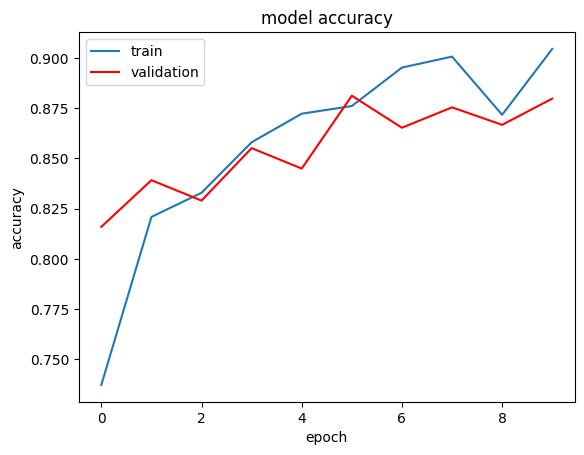

In [15]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

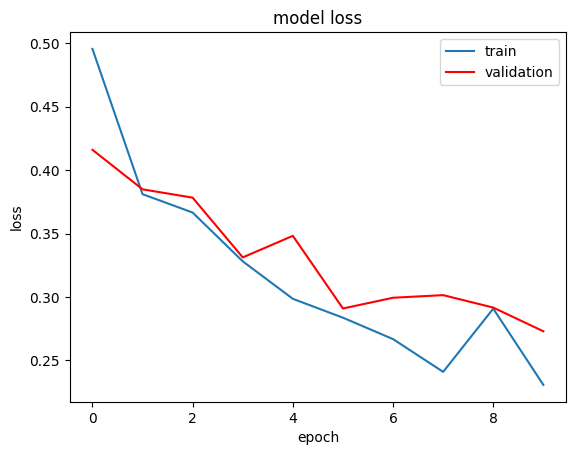

In [16]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

# **Prediction**

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(test_set)
y_pred = y_pred.round()
y_true = test_set.classes
print(classification_report(y_true,y_pred))

22/22 [==============================] - 384s 17s/step
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       345
           1       0.52      0.52      0.52       345

    accuracy                           0.52       690
   macro avg       0.52      0.52      0.52       690
weighted avg       0.52      0.52      0.52       690



In [18]:
predictions = model.predict(test_set)
y_pred = (predictions > 0.5).astype("int32")

22/22 [==============================] - 389s 18s/step


In [19]:
y_pred

array([[1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [20]:
# my_model = model.save('2_Transfer_Learning.h5')

In [21]:
# import seaborn as sns
# from sklearn.metrics import precision_score, recall_score, roc_auc_score
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_curve
# import cv2, os, random

# **Evaluation**

In [23]:
from sklearn.metrics import classification_report
train_score = model.evaluate(training_set, batch_size=32)
test_score = model.evaluate(test_set, steps=test_set.samples, batch_size=32)

print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print('-' * 20)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])
print('-' * 20)


# print(classification_report(test_set.classes, y_pred, target_names=["Early_Cancer", "Non_Cancer_Classified"]))

 22/690 [..............................] - ETA: 3:14:02 - loss: 0.2729 - accuracy: 0.8797

690/690 [==============================] - 384s 531ms/step - loss: 0.2729 - accuracy: 0.8797
Train Loss: 0.22070473432540894
Train Accuracy: 0.9060622453689575
--------------------
Test Loss: 0.27289336919784546
Test Accuracy: 0.8797101378440857
--------------------


# **CM**

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 1000x1000 with 0 Axes>

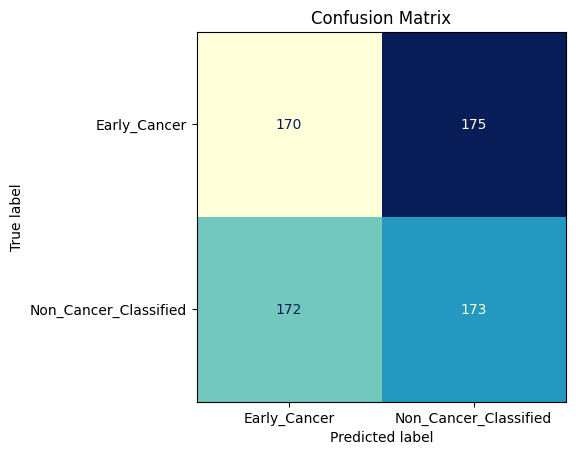

In [28]:
test_matrix = confusion_matrix(y_true, y_pred)

class_labels = list(test_set.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')

plt.show()

# **Ploting using Matplotlib**

# **Prediction**

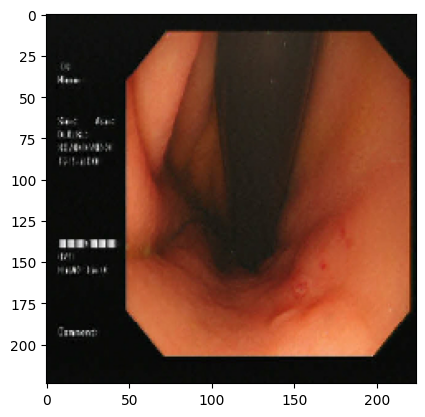

The probability of Early Cancer is:  [0.65353525]


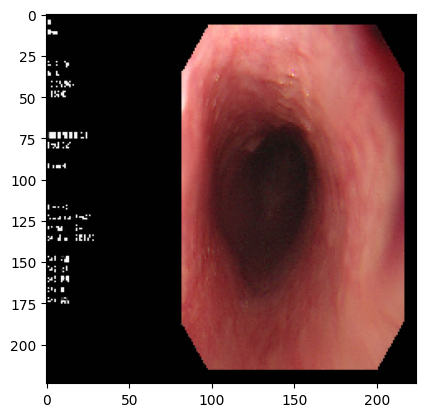

The probability of Early Cancer is:  [0.96873116]


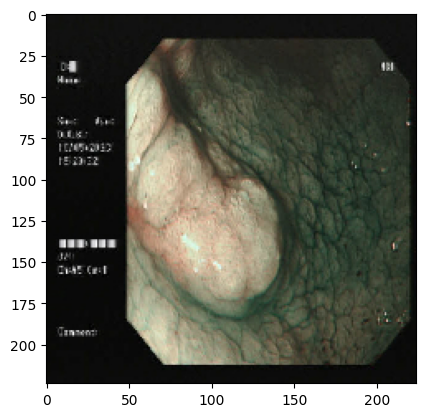

The probability of Early Cancer is:  [0.16473559]


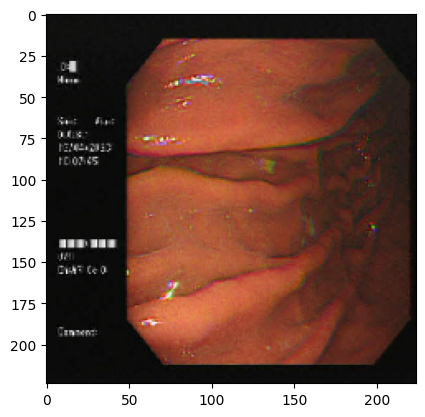

The probability of Early Cancer is:  [0.7998902]


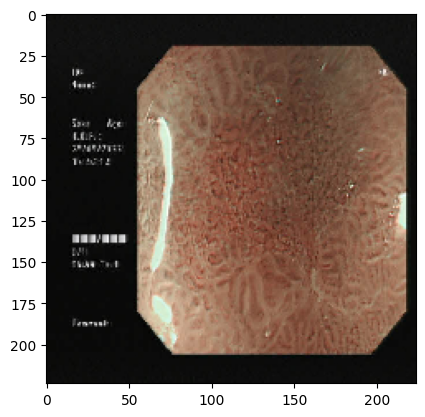

The probability of Early Cancer is:  [0.18168074]


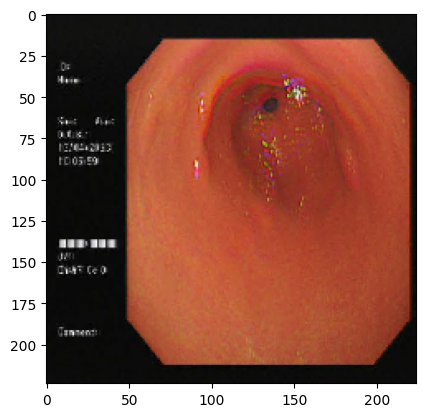

The probability of Early Cancer is:  [0.5055459]


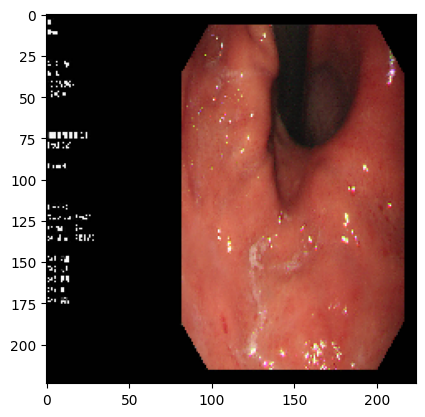

The probability of Early Cancer is:  [0.16400768]


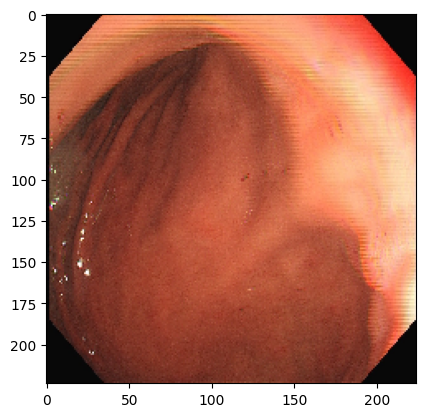

The probability of Early Cancer is:  [0.22306767]


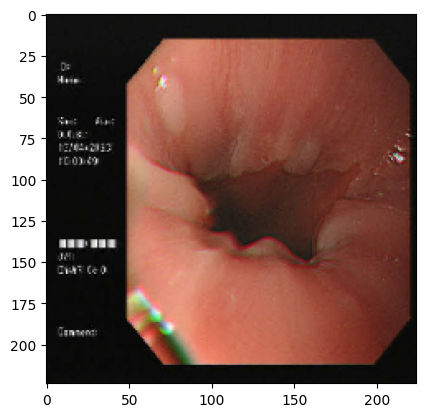

The probability of Early Cancer is:  [0.89903516]


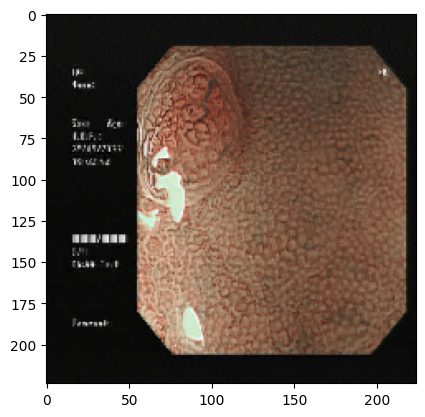

The probability of Early Cancer is:  [0.9580484]


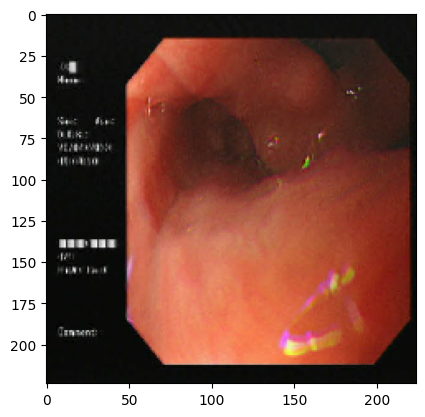

The probability of Early Cancer is:  [0.9231831]


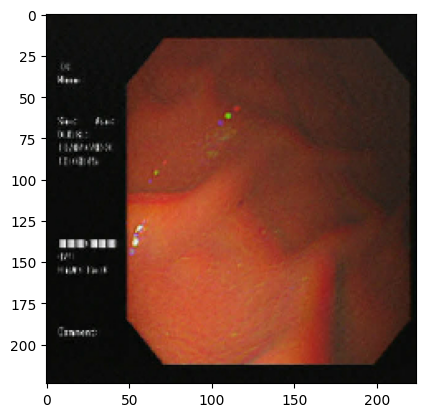

The probability of Early Cancer is:  [0.9644715]


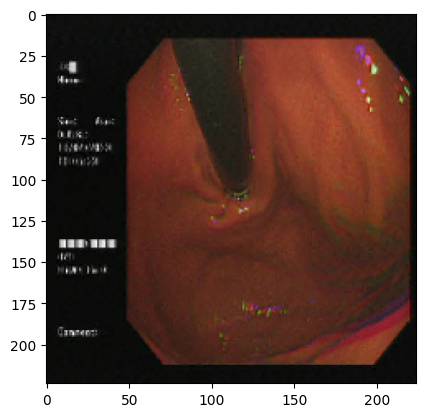

The probability of Early Cancer is:  [0.06212509]


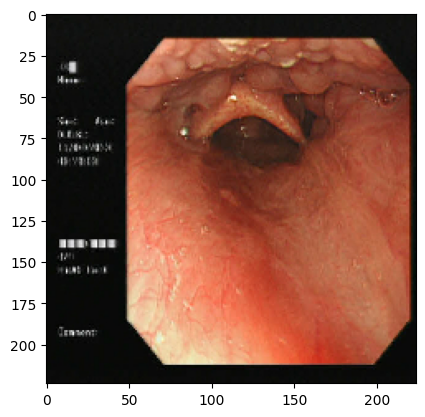

The probability of Early Cancer is:  [0.82308304]


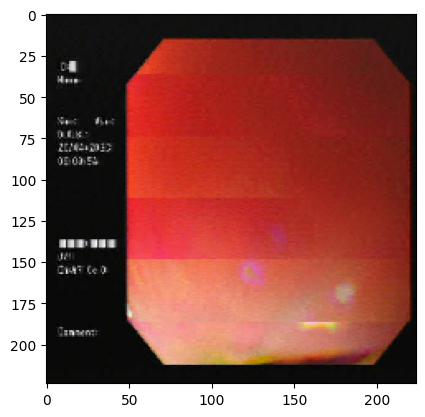

The probability of Early Cancer is:  [0.75734466]


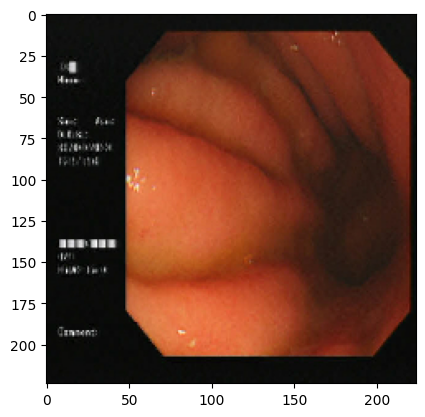

The probability of Early Cancer is:  [0.04721017]


In [32]:
x=test_set.next()
for i in range(0,1):
  image = x[i]
  for j in range(0, 16):
    plt.imshow(image[j])
    plt.show()
    print("The probability of Early Cancer is: ", predictions[j])

# **Save Model**

In [33]:
my_model = model.save('Early_Cancer_detection_trans(10).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
